### 0. lib and file load 

In [1]:

import pandas as pd
import numpy as np # pip install numpy==1.21

# 시각화 
import matplotlib.pyplot as plt
from fbprophet.plot import add_changepoints_to_plot

# 모델링
from prophet import Prophet

# 정규화 
from sklearn.preprocessing import MinMaxScaler

# hyperparameter search  
from bayes_opt import BayesianOptimization

# 평가
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

/home/ubuntu2/anaconda3/envs/kcit-ext/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 파일을 불러오고 저장할 경로 설정

save_path = '/home/ubuntu2/workspace/JYK/kcit/data/preprocessed'

# 데이터 로드 

train = pd.read_parquet(f'{save_path}/train_denoised.parquet')
test = pd.read_parquet(f'{save_path}/test_denoised.parquet')
#valid = pd.read_parquet(f'{save_path}/valid_denoised.parquet')

In [3]:
train

유속(Cm/S)  수위(mm)  유량(M3/H)  위치  기온(°C)  1분 강수량(mm)  \
날짜 및 시간                                                                   
2022-01-31 23:50:00      34.4   560.7     141.0  19     0.4         0.0   
2022-01-31 23:40:00      23.1   553.9     123.0  19     0.5         0.0   
2022-01-31 23:30:00      42.4   545.7     152.0  19     0.0         0.0   
2022-01-31 23:20:00      51.2   537.4     163.0  19     0.0         0.0   
2022-01-31 23:10:00      58.1   529.4     171.0  19    -0.1         0.0   
...                       ...     ...       ...  ..     ...         ...   
2020-01-01 00:40:00       1.9     1.1      66.0  19    -6.5         0.0   
2020-01-01 00:30:00       1.7     0.8      65.0  19    -6.5         0.0   
2020-01-01 00:20:00       1.1     0.5      61.0  19    -6.8         0.0   
2020-01-01 00:10:00       1.7     0.2      65.0  19    -6.8         0.0   
2020-01-01 00:00:00       1.3     0.0      62.0  19    -7.0         0.0   

                     강수유무(유무)  풍향(deg)  풍속(m/s)  수위(mm)_denoised  
날짜 및 시간                                                           
2022-01-31 23:50:00       0.0    332.7      0.6       157.950401  
2022-01-31 23:40:00      10.0    232.8      2.2       158.481963  
2022-01-31 23:30:00      10.0    192.0      0.8       159.013532  
2022-01-31 23:20:00      10.0    210.3      0.5       159.545101  
2022-01-31 23:10:00      10.0    181.1      1.3       160.076665  
...                       ...      ...      ...              ...  
2020-01-01 00:40:00       0.0    182.7      1.1       155.292941  
2020-01-01 00:30:00       0.0    153.3      0.0       155.824364  
2020-01-01 00:20:00       0.0    204.2      0.6       156.355828  
2020-01-01 00:10:00       0.0    209.6      1.3       156.887327  
2020-01-01 00:00:00       0.0    147.3      0.1       157.418854  

[109668 rows x 10 columns]

In [4]:
# 시각화 전 한글 깨짐 방지

plt.rcParams['font.family'] = 'NanumGothic'

In [5]:
target = '수위(mm)'

y_train = train[target]
y_test = test[target]
#y_valid = valid[target]

In [6]:
def split_and_drop(df):
    df = df[df['위치'] == 19]
    # df = df.drop(target, axis=1)
    df.interpolate(method='values', inplace=True)

In [7]:
split_and_drop(train), split_and_drop(test)
# , split_and_drop(valid)

(None, None)

### 2. modeling

##### 2-1. 다른 feature 없이 target인 '수위'만으로 모델링

1) unscaled, undenoised data

In [8]:
# ds, y로 변경해 줌

train_df = train.copy().reset_index()
train_df = train_df[['날짜 및 시간', '수위(mm)']]
train_df.rename(columns = {'날짜 및 시간':'ds', '수위(mm)':'y'}, inplace = True) 

test_df = test.copy().reset_index()
test_df = test_df[['날짜 및 시간', '수위(mm)']]
test_df.rename(columns = {'날짜 및 시간':'ds', '수위(mm)':'y'}, inplace = True) 

'''
valid_df = valid.copy().reset_index()
valid_df = valid_df[['날짜 및 시간', '수위(mm)']]
valid_df.rename(columns = {'날짜 및 시간':'ds', '수위(mm)':'y'}, inplace = True)'''

"\nvalid_df = valid.copy().reset_index()\nvalid_df = valid_df[['날짜 및 시간', '수위(mm)']]\nvalid_df.rename(columns = {'날짜 및 시간':'ds', '수위(mm)':'y'}, inplace = True)"

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
/home/ubuntu2/anaconda3/envs/kcit-ext/lib/python3.8/site-packages/prophet/plot.py:92: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
/home/ubuntu2/anaconda3/envs/kcit-ext/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/home/ubuntu2/anaconda3/envs/kcit-ext/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


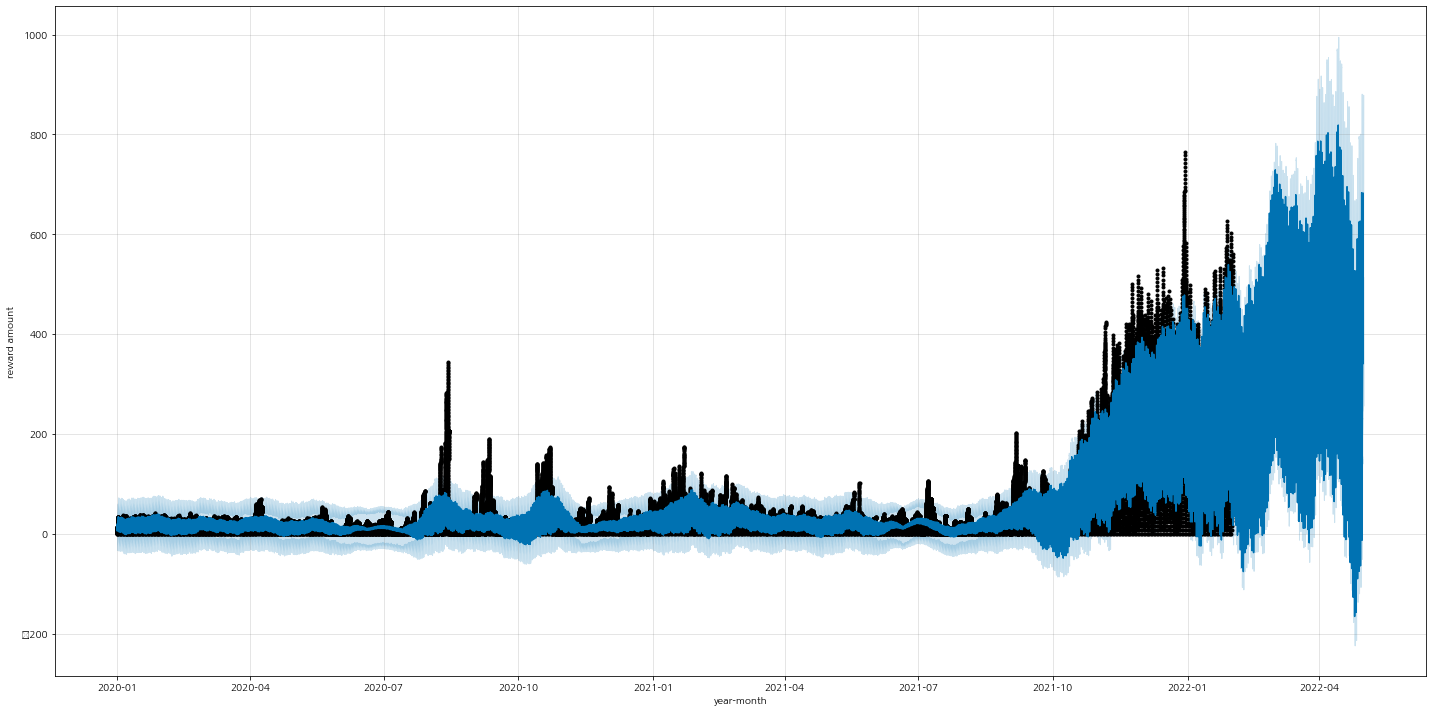

In [39]:
model_1 = Prophet(changepoint_prior_scale='0.5',
                seasonality_prior_scale='5',
                yearly_seasonality='auto', 
                seasonality_mode='multiplicative')
model_1.add_seasonality(name='monthly', period=30.5, fourier_order=5) # 월 주기 추가
model_1.fit(train_df)

future_1 = model_1.make_future_dataframe(freq='10min', periods=12816) # periods: 추가로 예측할 횟수, freq: 단위: 여기서는 10분
pred_1 = model_1.predict(future_1)

fig1 = model_1.plot(pred_1, figsize=(20, 10), xlabel='year-month', ylabel='reward amount')

In [10]:
pred_1.sort_values('ds', ascending=False)

ds       trend  yhat_lower  yhat_upper  trend_lower  \
122339 2022-04-29 23:50:00  448.121264  258.842783  452.005713   328.527594   
122338 2022-04-29 23:40:00  448.109062  280.301986  501.657348   328.526675   
122337 2022-04-29 23:30:00  448.096859  306.721597  548.233747   328.525755   
122336 2022-04-29 23:20:00  448.084656  336.730099  601.988468   328.524836   
122335 2022-04-29 23:10:00  448.072453  362.631516  645.497256   328.523917   
...                    ...         ...         ...         ...          ...   
4      2020-01-01 00:40:00   18.577906  -25.931365   49.291829    18.577906   
3      2020-01-01 00:30:00   18.577067  -25.834186   47.325615    18.577067   
2      2020-01-01 00:20:00   18.576229  -20.722147   51.618406    18.576229   
1      2020-01-01 00:10:00   18.575390  -20.209284   53.410473    18.575390   
0      2020-01-01 00:00:00   18.574551  -20.148581   55.498374    18.574551   

        trend_upper     daily  daily_lower  daily_upper   monthly  ...  \
122339   563.824132  0.026884     0.026884     0.026884  0.160227  ...   
122338   563.810579  0.119069     0.119069     0.119069  0.160041  ...   
122337   563.797027  0.209406     0.209406     0.209406  0.159853  ...   
122336   563.783475  0.296566     0.296566     0.296566  0.159662  ...   
122335   563.769923  0.379293     0.379293     0.379293  0.159470  ...   
...             ...       ...          ...          ...       ...  ...   
4         18.577906 -0.413976    -0.413976    -0.413976  0.020882  ...   
3         18.577067 -0.332901    -0.332901    -0.332901  0.021137  ...   
2         18.576229 -0.247007    -0.247007    -0.247007  0.021393  ...   
1         18.575390 -0.157528    -0.157528    -0.157528  0.021651  ...   
0         18.574551 -0.065776    -0.065776    -0.065776  0.021910  ...   

          weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
122339  0.039299      0.039299      0.039299 -0.437600     -0.437600   
122338  0.039142      0.039142      0.039142 -0.437702     -0.437702   
122337  0.038977      0.038977      0.038977 -0.437803     -0.437803   
122336  0.038802      0.038802      0.038802 -0.437904     -0.437904   
122335  0.038619      0.038619      0.038619 -0.438005     -0.438005   
...          ...           ...           ...       ...           ...   
4       0.062063      0.062063      0.062063 -0.000539     -0.000539   
3       0.061424      0.061424      0.061424 -0.000407     -0.000407   
2       0.060776      0.060776      0.060776 -0.000275     -0.000275   
1       0.060120      0.060120      0.060120 -0.000142     -0.000142   
0       0.059455      0.059455      0.059455 -0.000010     -0.000010   

        yearly_upper  additive_terms  additive_terms_lower  \
122339     -0.437600             0.0                   0.0   
122338     -0.437702             0.0                   0.0   
122337     -0.437803             0.0                   0.0   
122336     -0.437904             0.0                   0.0   
122335     -0.438005             0.0                   0.0   
...              ...             ...                   ...   
4          -0.000539             0.0                   0.0   
3          -0.000407             0.0                   0.0   
2          -0.000275             0.0                   0.0   
1          -0.000142             0.0                   0.0   
0          -0.000010             0.0                   0.0   

        additive_terms_upper        yhat  
122339                   0.0  353.482619  
122338                   0.0  394.582340  
122337                   0.0  434.847346  
122336                   0.0  473.682084  
122335                   0.0  510.523689  
...                      ...         ...  
4                        0.0   12.418035  
3                        0.0   13.918921  
2                        0.0   15.509052  
1                        0.0   17.165514  
0                        0.0   18.863905  

[122340 rows x 25 columns]

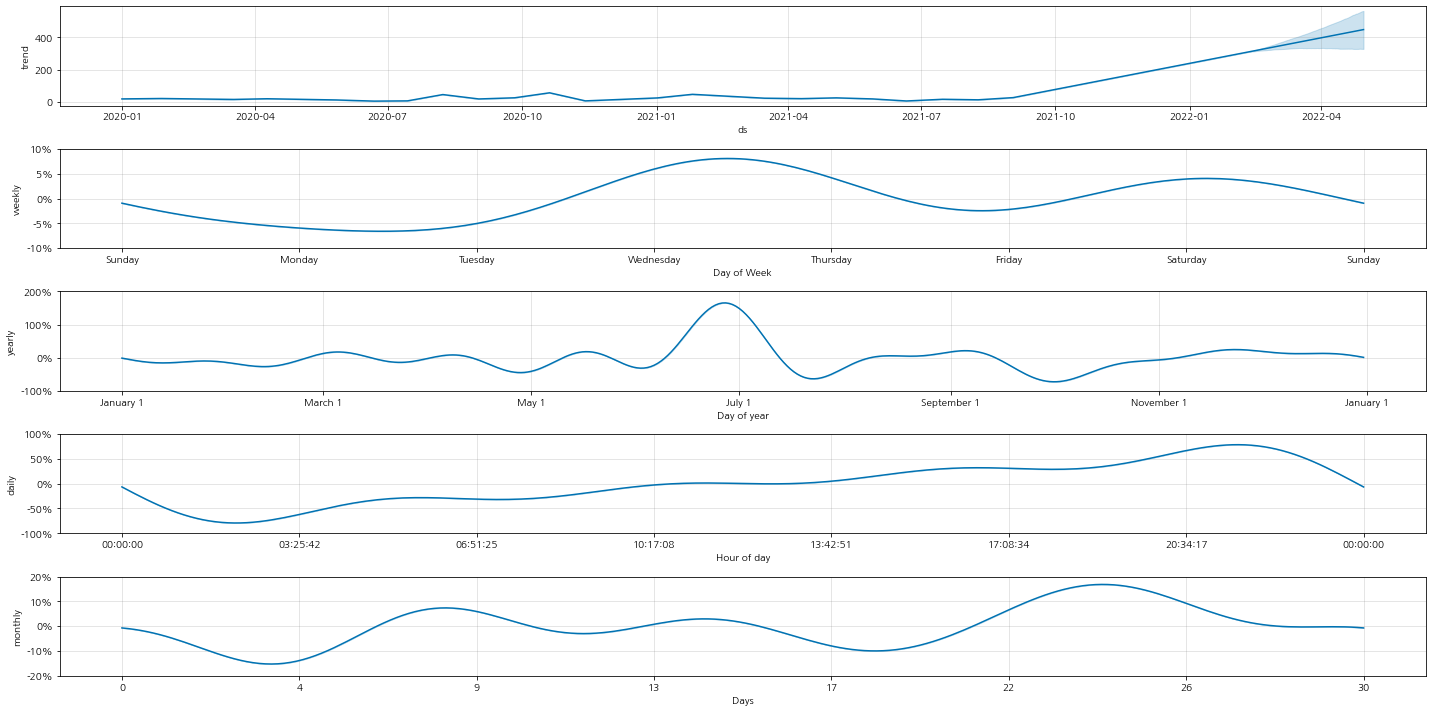

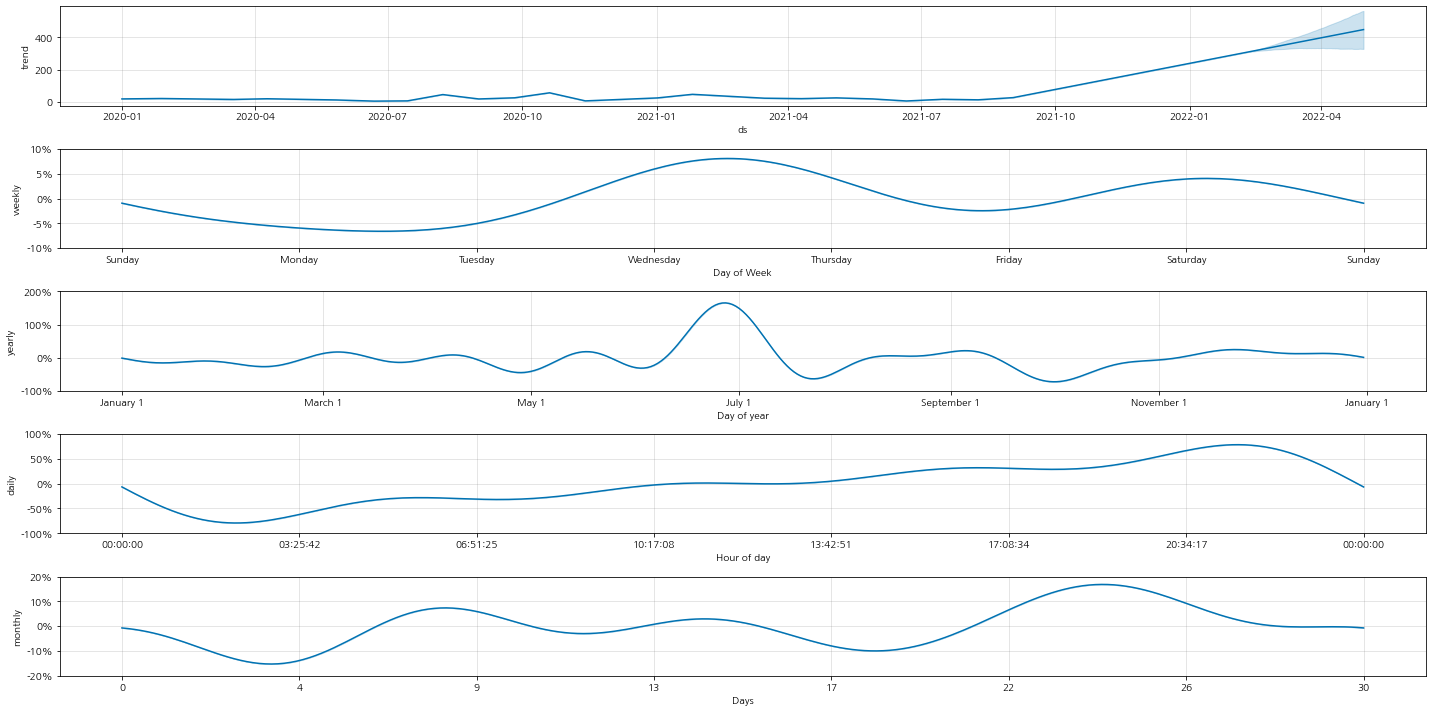

In [37]:
# 컴포넌트 시각화

model_1.plot_components(pred_1, figsize=(20, 10))

##### 2) denoised data 적용

In [12]:
train_df_f = train.copy().reset_index()
train_df_f.rename(columns = {'날짜 및 시간':'ds', '수위(mm)_denoised':'y'}, inplace = True) 
train_df_f = train_df_f[['ds','y']]

test_df_f = test.copy().reset_index()
test_df_f.rename(columns = {'날짜 및 시간':'ds', '수위(mm)_denoised':'y'}, inplace = True) 
test_df_f = test_df[['ds', 'y']]
'''
valid_df_f = valid.copy().reset_index()
valid_df_f.rename(columns = {'날짜 및 시간':'ds', '수위(mm)_denoised':'y'}, inplace = True) 
valid_df_f = valid_df[['ds', 'y']]'''

"\nvalid_df_f = valid.copy().reset_index()\nvalid_df_f.rename(columns = {'날짜 및 시간':'ds', '수위(mm)_denoised':'y'}, inplace = True) \nvalid_df_f = valid_df[['ds', 'y']]"

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


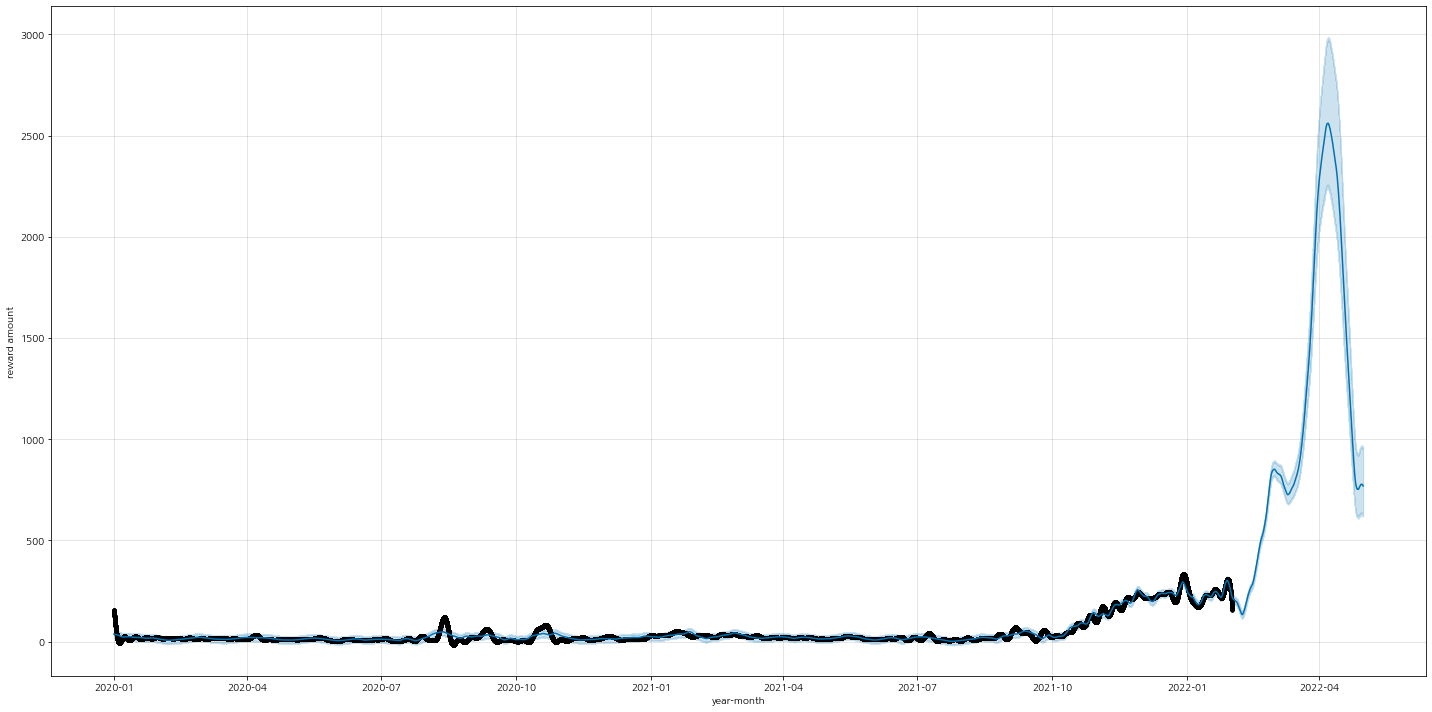

In [13]:
model_2 = Prophet(changepoint_prior_scale='0.3',
                yearly_seasonality='10', 
                seasonality_mode='multiplicative')
model_2.add_seasonality(name='monthly', period=30.5, fourier_order=5) # 월 주기 추가
model_2.fit(train_df_f)
pred_2 = model_2.predict(test_df_f)

future_2 = model_2.make_future_dataframe(freq='10min', periods=12816) # periods: 추가로 예측할 횟수, freq: 단위: 여기서는 10분
pred_2 = model_2.predict(future_2)

model_2.plot(pred_2, figsize=(20, 10), xlabel='year-month', ylabel='reward amount')

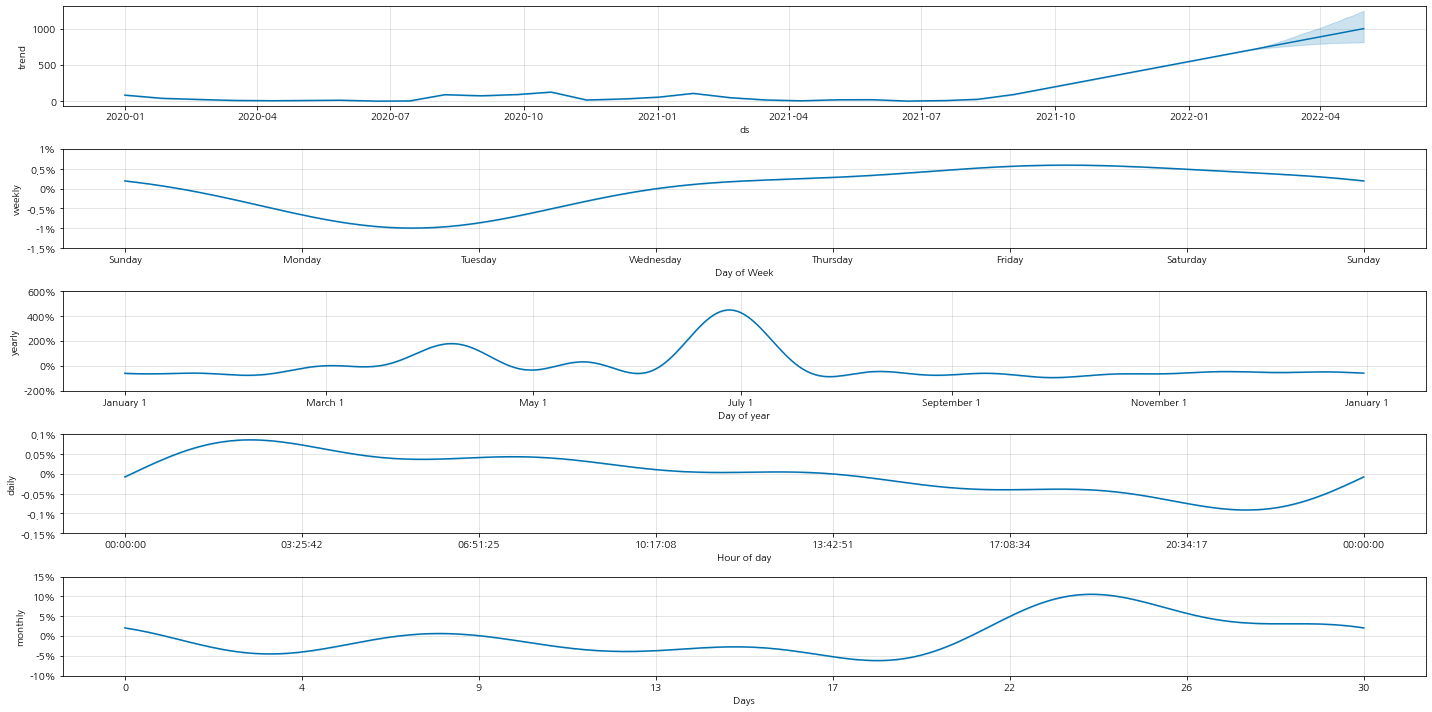

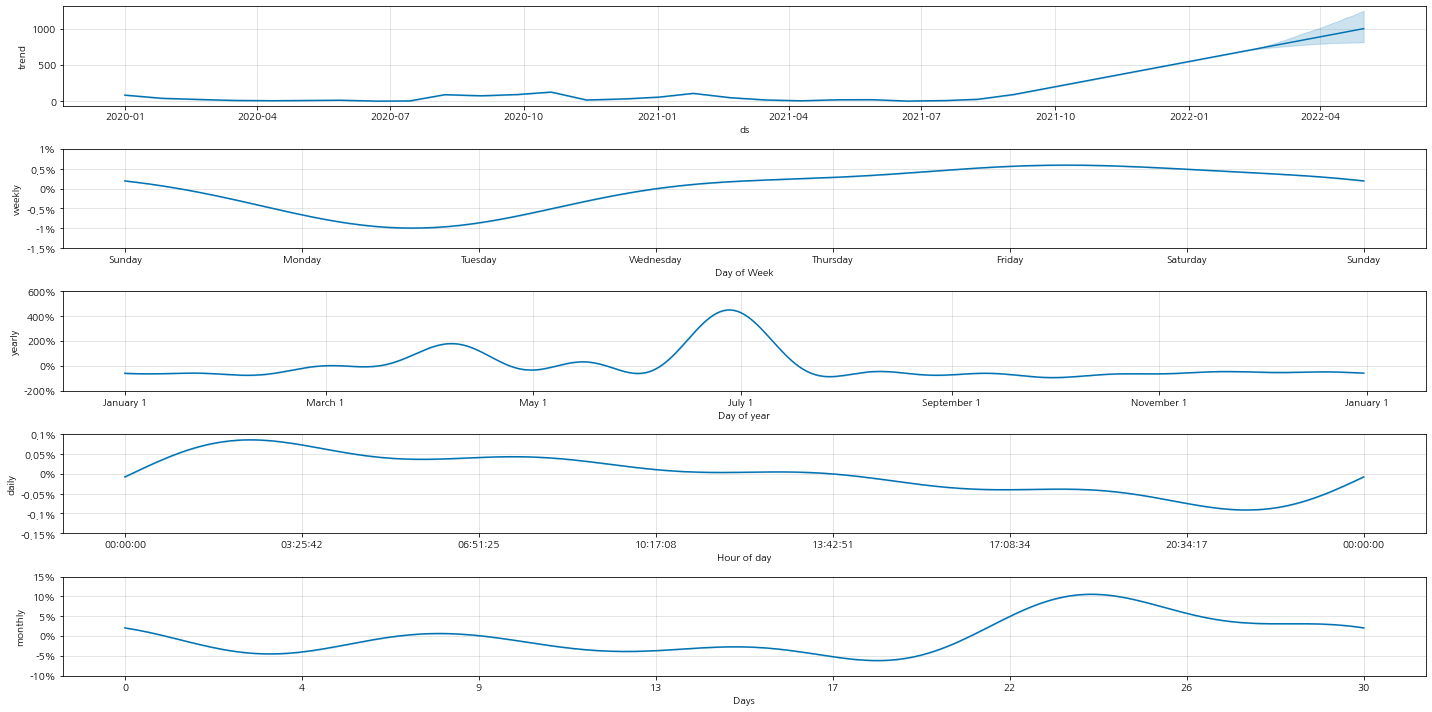

In [36]:
model_2.plot_components(pred_2, figsize=(20, 10))

##### 2-2. 다른 feature를 추가한 모델 만들기(보류)

In [206]:
# 정규화 함수 정의

scaler = MinMaxScaler()

# 인덱스를 제외하고, 컬럼만 추출하여 정규화

def scaling(df):
    columns = list(df.columns)
    df[columns] = scaler.fit_transform(df[columns])
    df

scaling(train), scaling(test), scaling(valid)

(None, None, None)

In [207]:
train.interpolate(method='values', inplace=True)
test.interpolate(method='values', inplace=True)
valid.interpolate(method='values', inplace=True)

In [208]:
# target인 '수위'를 제외한 나머지 column들을 feature로 사용하기 위해 regressor 선언 

regressors = list(train.columns[1:])
regressors

['수위(mm)',
 '유량(M3/H)',
 '위치',
 '기온(°C)',
 '1분 강수량(mm)',
 '강수유무(유무)',
 '풍향(deg)',
 '풍속(m/s)',
 '수위(mm)_denoised']

### 3. 보완

##### 3-1. hyperparameter search (보류)

In [41]:
# params

search_params = {
 'changepoint_prior_scale': [0.001, 0.05, 0.1, 0.5],
 'seasonality_prior_scale': [0.05, 0.1, 1.0, 10.0],
 'holidays_prior_scale': 0.01, # 기상과 관련한 데이터이므로 최솟값으로 설정
 'seasonality_mode': ['additive', 'multiplicative']
}

In [42]:
# Bayesian optimization 객체 생성
# f: 탐색 대상 함수, pbounds: hyperparameter 집합
# verbose = 2 항상 출력, verbose = 1 최댓값일 때 출력, verbose = 0 출력 안함
# random_state: Bayesian Optimization 상의 랜덤성이 존재하는 부분을 통제 

bo = BayesianOptimization(f=model_2, pbounds=search_params, verbose=1, random_state=1 )    

# 메소드를 이용해 최대화 과정 수행
# init_points: 초기 Random Search 갯수
# n_iter: 반복 횟수 (몇개의 입력값-함숫값 점들을 확인할지! 많을수록 정확한 값을 얻을 수 있다.)
# acq: Acquisition Function들 중 Expected Improvement(EI) 를 사용
# xi: exploration 강도 (기본값은 0.0)

bo.maximize(init_points=2, n_iter=10, acq='ei', xi=0.01)

# ‘iter’는 반복 회차, ‘target’은 목적 함수의 값, 나머지는 입력값을 나타냅니다. 
# 현재 회차 이전까지 조사된 함숫값들과 비교하여, 현재 회차에 최댓값이 얻어진 경우, 
# bayesian-optimization 라이브러리는 이를 자동으로 다른 색 글자로 표시하는 것을 확인할 수 있습니다

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

In [ ]:
# 찾은 파라미터 값 확인
print(bo.max)

##### 3-2. denoised data 적용

### 4. 평가

4-1. undenoised dataset

In [68]:
train_df.shape, pred_1.shape, train_df_f.shape, pred_2.shape

((109668, 2), (122484, 25), (109668, 2), (122484, 25))

In [69]:
# train set evaluation

print(f'============== train {target} Evaluate Result ============')
print('MAE:', mean_absolute_error(train_df['y'], pred_1['yhat'][:109668]))
print('MSE:', mean_squared_error(train_df['y'], pred_1['yhat'][:109668]))
print('RMS:', (mean_squared_error(train_df['y'], pred_1['yhat'][:109668]))**2)
print('MAPE:', mean_absolute_percentage_error(train_df['y'], pred_1['yhat'][:109668]))

============== train 수위(mm) Evaluate Result ============
MAE: 69.54432597489428
MSE: 14361.068115831322
RMS: 206240277.42754698
MAPE: 3557247160231591.5


In [70]:
test_df.shape, test_df_f.shape

((12808, 2), (12808, 2))

In [47]:
# test set evaluation

test_y = test_df['y']
test_pred = pred_1['yhat']
print(f'============== test {target} Evaluate Result ============')
print('MAE:', mean_absolute_error(test_y, test_pred[:12808]))
print('MSE:', mean_squared_error(test_y, test_pred[:12808]))
print('RMS:', (mean_squared_error(test_y, test_pred[:12808]))**2)
print('MAPE:', mean_absolute_percentage_error(test_y, test_pred[:12808]))

============== test 수위(mm) Evaluate Result ============
MAE: 101.37883578570826
MSE: 34642.1877492272
RMS: 1200081172.0527074
MAPE: 775319881383338.9


4-2. denoised dataset

In [35]:
# denoised train set evaluation

train_y_f = train_df_f['y']
train_pred_f = pred_2['yhat']
print(f'============== denoised train {target} Evaluate Result ============')
print('MAE:', mean_absolute_error(train_y_f, train_pred_f[:109668]))
print('MSE:', mean_squared_error(train_y_f, train_pred_f[:109668]))
print('RMS:', (mean_squared_error(train_y_f, train_pred_f[:109668]))**2)
print('MAPE:', mean_absolute_percentage_error(train_y_f, train_pred_f[:109668]))

============== denoised train 수위(mm) Evaluate Result ============
MAE: 62.72568466015359
MSE: 10721.934632428934
RMS: 114959882.26207899
MAPE: 5.155036942477504


In [19]:
# denoised set evaluation

test_y = test_df['y']
test_pred = pred_2['yhat']
print(f'============== test {target} Evaluate Result ============')
print('MAE:', mean_absolute_error(test_y, test_pred[:12808]))
print('MSE:', mean_squared_error(test_y, test_pred[:12808]))
print('RMS:', (mean_squared_error(test_y, test_pred[:12808]))**2)
print('MAPE:', mean_absolute_percentage_error(test_y, test_pred[:12808]))

============== test 수위(mm) Evaluate Result ============
MAE: 99.80323880278604
MSE: 34147.90489046734
RMS: 1166079408.4084032
MAPE: 593774774351784.2
